# Long Short Term Memory

In this notebook, we use a Long Short Term Memory Neural Network (LSTM) model to classify time series data. This model is built using the `tensorflow` and `keras` libraries, similar to the networks we constructed yesterday.

The notebook is split into the following sections:
1. Investigate the data
2. Construct an LSTM model
3. Evaluate the model

Author: Joshua Pickard (jpic@umich.edu)

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM  
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import model_selection
import glob
import random

## Human Activity Recognition Using Smartphones Data Set

We will be using machine learning to preform Human Activity Recognition (HAR) for the following 3 activities:

1. Running
2. Stationary
3. Walking

To do this, we will analyze 3 signals collected from people as they preformed these activities. Participants wore a Samsung Galaxy S II. Using its embedded accelerometer and gyroscope, 3-axial linear acceleration and 3-axial angular velocity were recorded at a constant rate of 50Hz.

The acceleration measurements taken for each dimension (x, y, z) will be the input data our models consider. Each sample of data contains all 3 acceleration measurements for 1000 points in time.

For more information on the dataset, please see: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones


In the below cell, a `.zip` file is downloaded from the given url, and each file is unpacked. The files come in the form of `csv` files, where each column is an acceleration measurement in 1 dimension, each row is a point in time, and each file is one sample.

**Turn this cell into a Code cell to download and unzip the data**

# for Windows

In [4]:
!pip install wget


In [5]:
import requests

url = "https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip"
filename = url.split("/")[-1]

response = requests.get(url, stream=True)
response.raise_for_status()  # Raise an error for bad responses

with open(filename, 'wb') as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

print(f"Downloaded {filename} successfully!")

Downloaded dataset.zip successfully!


In [6]:
import zipfile

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(".")  # extracts to the current directory
print(f"Extracted {filename} successfully!")

Extracted dataset.zip successfully!


# For Mac environment 

## Loading the Data

The data has been downloaded to the `dataset/` directory and can be viewed with the file icon on the left hand side of the page. The following cell of code loads the data to `X` and `y` variables representing a sample of recordings and an action label.

In [7]:
# Load data into memory
labels = ['stationary', 'walking', 'running']
x_recordings = []
y_recordings = []
recordings_filenames = []
for i, label in enumerate(labels):
    filenames = glob.glob('dataset/' + label + '/*.csv')
    for filename in filenames:
        data = np.loadtxt(filename, delimiter=',')
        x_recordings.append(data)
        y_recordings.append(i)
        recordings_filenames.append(filename)

x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 3)
y_recordings = np.array(y_recordings)

print(x_recordings.shape)
print(y_recordings.shape)

(92, 1000, 3)
(92,)


From the output above, we see the shape of `x_recordings`, the data we downloaded, is `(92, 1000, 3)`. There are 3 measurements taken at any time, 1000 time points per sample, and 92 samples in all.

## Visualize the Data

The code below generates a few plots to visualize what different sample look like when plotted over time. It appears as if each activity has its own set of trends in terms of how it appears. If we were doing feature selction or signals processing, we may be itnerested in smoothing or otherwise modifying this dataset to remove noise in the data.

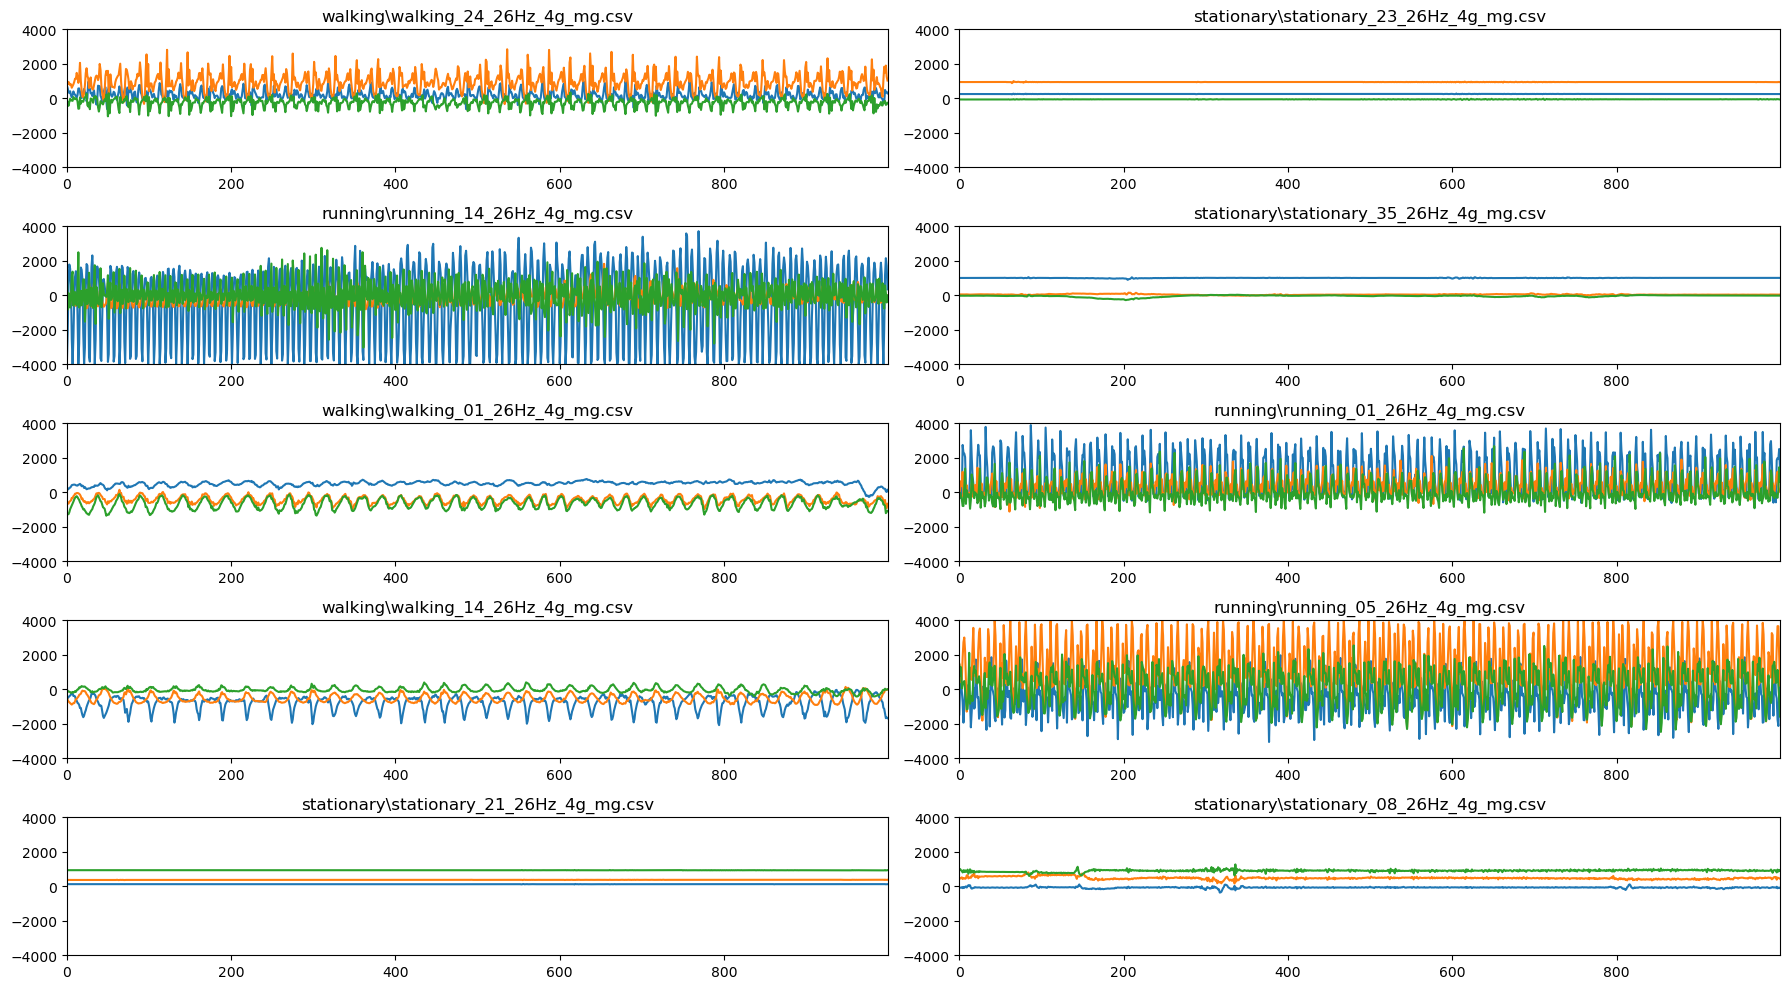

In [8]:
# Plot some captures
unique_rands = random.sample(range(len(x_recordings)), 10)
plt.figure(figsize=(18, 10))
for i, n in enumerate(unique_rands):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-4000, 4000)  # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
plt.tight_layout()
plt.show()

## Class Balance
As we have seen, it is important to understand the class balance of a data set. In the case of the HAR classification problem, we are interested in knowing how many examples of each type of activity we have in the data set. In the following cell, we explore this.

In [9]:
# convert the numpy array into a dataframe
df = pd.DataFrame(y_recordings)
counts = df.groupby(0).size()
counts = counts.values

# summarize
print('Training Data Set:')
for i in range(len(counts)):
    percent = counts[i] / len(df) * 100
    print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

Training Data Set:
Class=1, total=36, percentage=39.130
Class=2, total=39, percentage=42.391
Class=3, total=17, percentage=18.478


Now that we have loaded and visualized a few realizations of our data, we partition the data into training and validation datasets.

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(x_recordings, y_recordings)

# Verify that the data split correctly
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(69, 1000, 3)
(23, 1000, 3)
(69,)
(23,)


# Build and Test your Model

In this next section, we build and evaluate a LSTM model on this time series data.

### Reformat the Labels

In the next cell, we reformat the labels to be compatable with the `Sequential` model from `tensorflow`. This reformats the labels into One Hot Encodings, which is a different format than we used when generating the plots above.

The labels for walking, sitting, and running are numeric values, but there is no ordinal relationship between these activities. As a result, we transform the labels to a representation that does not assign an order to each activity.

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
print(y_train.shape)
print(y_test.shape)

(69, 3)
(23, 3)


## Constructing the LSTM Model

This syntax is nearly identical to the synatx used to construct CNN or Feedforward networks. The key difference is the first layer is `LSTM` to make use of this time series.

In [13]:
model = Sequential()

# LSTM layer
model.add(LSTM(100, input_shape=(1000, 3)))
model.add(Dropout(0.5))

# fill in the activations as sigmoid, softmax, relu, or tanh
model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='relu'))

# Do not change this line
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               41600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 15)                1515      
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 43,308
Trainable params: 43,308
Non-trainable params: 0
_________________________________________________________________


In [15]:
plot_model(model, show_shapes=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
# fit network
epochs = 30
history = model.fit(X_train, y_train, epochs=epochs)

Epoch 1/30
3/3 [==============================] - 2s 190ms/step - loss: 1.1837 - auc: 0.4325
Epoch 2/30
3/3 [==============================] - 1s 205ms/step - loss: 1.1565 - auc: 0.4517
Epoch 3/30
3/3 [==============================] - 1s 218ms/step - loss: 1.0629 - auc: 0.5571
Epoch 4/30
3/3 [==============================] - 1s 212ms/step - loss: 1.0841 - auc: 0.5385
Epoch 5/30
3/3 [==============================] - 1s 267ms/step - loss: 1.0296 - auc: 0.6070
Epoch 6/30
3/3 [==============================] - 1s 195ms/step - loss: 1.0640 - auc: 0.5615
Epoch 7/30
3/3 [==============================] - 1s 204ms/step - loss: 1.0268 - auc: 0.6114
Epoch 8/30
3/3 [==============================] - 1s 209ms/step - loss: 1.0174 - auc: 0.6067
Epoch 9/30
3/3 [==============================] - 1s 199ms/step - loss: 1.0239 - auc: 0.6268
Epoch 10/30
3/3 [==============================] - 1s 213ms/step - loss: 1.0353 - auc: 0.5852
Epoch 11/30
3/3 [==============================] - 1s 194ms/step - lo

Text(0.5, 1.0, 'AUC During Training')

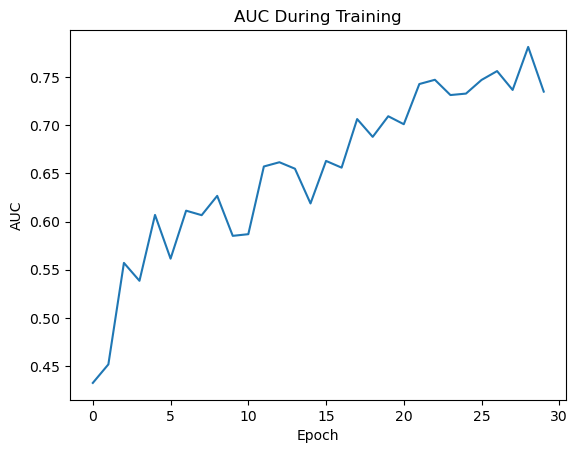

In [17]:
plt.plot(history.history['auc'])
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.title('AUC During Training')

Finally, we can evaluate this trained model on the test data set.

In [18]:
_, AUC = model.evaluate(X_test, y_test)
print('AUC', AUC) 

1/1 [==============================] - 1s 511ms/step - loss: 0.8992 - auc: 0.7112
AUC 0.7112476229667664
